# Clustering: k-means and Gaussian Mixture Models

Clustering algorithm consist in assigning points to centroids, and centroids are updated, this is repeated until convergence.  

Much of the difficulty in *using* clustering involves picking how many centroids to create and  how to initialize those centroids.   

In [1]:
from scipy.stats import multivariate_normal
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from sklearn.cluster import  KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import to_hex, to_rgb

# Read the data

In [3]:
# File Paths
mv_path = "mv.csv"
unif_path = "unif.csv"
mv2_path = "mv2.csv"
mv3_path = "mv3.csv"

# Read in Data
mv_df = pd.read_csv(mv_path, index_col = 0)
unif_df = pd.read_csv(unif_path, index_col = 0)
mv2_df = pd.read_csv(mv2_path, index_col = 0)
mv3_df = pd.read_csv(mv3_path, index_col = 0)

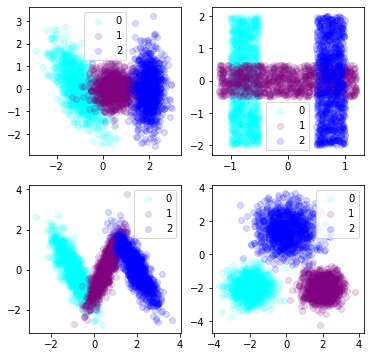

In [4]:
# Create Figure
fig, (axs) = plt.subplots(2,2, figsize = (6,6))

# Plot each ategory in each dataset as unique color
for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
    # cat = cateogry and col = color
    for cat, col in zip(df['cat'].unique(), ["cyan", "purple", "blue"]):
        ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, c = col, label = cat, alpha = .15)
    ax.legend()
    
plt.savefig('Cluster Categories')

As such each centroid will be defined by an $(x,y)$ pair of coordinates. 

---

### GMM Case

The clusters for the GMM model will also have a $2x2$ covariance matrix and a $\pi$ term.  

In the case of GMM models, each cluster center will be initialized with $\pi = \frac1k$  where $k$ is the number of clusters; and $\Sigma = \begin{bmatrix}
    1 & 0\\
    0&1
\end{bmatrix}$  

---

### Initializing clusters with K-means++

To initialize the clusters, a K-means++ type algorithm will be used.

K-means++ picks one point from the data to be the first cluster center. Subsequent cluster centers are picked from the remaining "unpicked" points. However, the probability of picking any one point is proportional to the euclidean distance from that point to the nearest cluster center squared.  

In [5]:
# Implement K-means ++ to initialize centers
def pick_cluster_centers(points, num_clusters = 3):
    # List to store clusters
    clusters = []
    
    # list of cluster indicies
    arr_idx = np.arange(len(points))
    
    # Choose first cluster; append to list
    clusters.append( points[np.random.choice(arr_idx)])
    
    # Define function to calculate squared Euclidean distance
    def dist_sq(x): return np.linalg.norm(x)**2
    
    c_dist = None

    # Add Clusters until reaching "num_clusters"
    while len(clusters) < num_clusters:
        
        # Calculate distance between latest cluster and rest of points
        new_dist = np.apply_along_axis(np.linalg.norm, 1, points - clusters[-1]).reshape(-1,1)
        
        # Add to distance array - First check to see if distance matrix exists
        if type(c_dist) == type(None):
            c_dist = new_dist
            
        else:
            c_dist = np.concatenate([c_dist, new_dist], axis = 1)
        
        # Calculate probability by finding shortest distance
        c_prob = np.apply_along_axis(np.min, 1, c_dist)
        # normalize the probability for the shortest distance
        c_prob = c_prob / c_prob.sum()

        # Draw new cluster according to probability
        clusters.append(points[np.random.choice(arr_idx, p = c_prob)])
            
    return np.array(clusters)

In [6]:
# Function to add pi and Sigma for GMM clusters
def build_GMM_clusters(clusters):
    return [(c, 1/len(clusters), np.array([[1,0],[0,1]])) for c in clusters]

### Describing Cluster Assignments
In hard clustering (only k-means in this assignment), each point is assigned exclusively to one cluster. In soft clustering (soft k-means and GMM), points may be portioned out between clusters.  

From now on allocation of points to clusters will be stored in a 2-d numpy array. And assume for the following examples that there are three clusters.  

i.e.

In k-means, if a point were assigned to cluster "0", its cluster assignment would be `[1,0,0]`. In the soft clustering, if the point were split evenly between the three clusters, it's cluster assignment would be `[.33,.33,.33]`.  

If there were three points, and two clusters, with k-means, the cluster-matrix might be:  

`np.array([[1,0],[1,0],[0,1]])` In this case, the first two points are assigned to cluster "0" and the third point is assigned to cluster "1".  

---

## Building Cluster Assignment Algorithms

For the point $i$; set cluster indicator $c_i$ to be the $k$ according to the equation $c_i =\text{argmin}_k\ ||x_i - \mu_k||^2$, where $k$ is one of the clusters.

In [7]:
def assign_clusters_k_means(points, clusters):
    # Find distances between each point and each cluster
    dists_to_clust = np.concatenate([np.apply_along_axis(np.linalg.norm, 1, points-c).reshape(-1,1) for c in clusters],axis = 1)
    
    # Function to convert minimum distance to 1 and others to 0
    def find_min(x):
        m = np.min(x)
        return [1 if n == m else 0 for n in x]
    
    # Apply function
    cluster_assignments = np.apply_along_axis( find_min, 1, dists_to_clust)
    
    return cluster_assignments

The proportion of a point $i$ that belongs to cluster $k$ is defined by the $\phi$ function for weighted k-means,  
$$\phi_i(k) = \frac{exp\{-\frac1\beta||x_i-\mu_k||^2\}}{\sum_jexp\{-\frac1\beta||x_i-\mu_j||^2\}}$$  

In [8]:
def assign_clusters_soft_k_means(points, clusters, beta):
    
    # Create function to calculate exponent
    # Take difference between point and cluster as input
    def calc_exp(x):
        return np.exp((-1/beta)* np.linalg.norm(x))
    
    # Find exponential weight for all point/cluster combonations
    clust_weights = np.concatenate([np.apply_along_axis(calc_exp, 1, points-c).reshape(-1,1) for c in clusters],axis = 1)
    
    # Normalize those weight
    def norm_clust_weights(x):
        return [n/np.sum(x) for n in x]

    cluster_weights = np.apply_along_axis(norm_clust_weights, 1, clust_weights)
    
    return cluster_weights

The proportion of a point $i$ that belongs to cluster $k$ is defined by the $\phi$ function for GMM:  

$$\phi_i(k) = \frac{\pi_k N(x_i|\mu_k,\Sigma_k)}{\sum_j \pi_j N(x_i|\mu_j,\Sigma_k)}$$ 

Note, $N(x_i|\mu_k,\Sigma_k)$ maybe found with `stats.multivariate_normal(mu,Sigma).pdf(x)` 

The `clusters` input will be a list of tuples. The tuples will be organized:  
($\mu$, $\pi$, $\Sigma$)
Where $\mu$ is a 1-d numpy array; $\pi$ is numeric, and $\Sigma$ is 2-d numpy array.

In [9]:
def assign_clusters_GMM(points, clusters):
    
    # Create function that creates a function which will
    # calculate the pdf given a mu and sigma, then multiply by pi
    def pdf_calc_func(mu, pi, Sigma):
        return lambda x: pi*stats.multivariate_normal(mu, Sigma).pdf(x)
    
    # Create list for saving weights
    clust_weights = []
    
    # For each cluster
    for c in clusters:
        # Create the custom pdf function
        pdf = pdf_calc_func(*c)
        
        # Apply to all the points
        clust_weights.append(np.apply_along_axis(pdf, 1, points).reshape(-1,1))
        
    # Combine all points
    clust_weights = np.concatenate(clust_weights, axis = 1)
    
    # Define normalizatino function and normalize
    def norm_clust_weights(x):
        return [n/np.sum(x) for n in x]
    
    cluster_assignments = np.apply_along_axis(norm_clust_weights, 1, clust_weights)
    
    return cluster_assignments

The centroid for cluster $k$ ($\mu_k$) should be updated with the equation:  

$$\mu_k = \frac{\sum_ix_i\mathbb{1}\{c_i = k\}}{\sum_i\mathbb{1}\{c_i = k\}}$$


In [10]:
def update_clusters_k_means(points, cluster_weights):
    
    # Create list to store new clusters
    new_clusts = []
    
    # For each column in "cluster_weights" which corresponds to a single cluster,
    # Average the location of all the points.
    for c in cluster_weights.T:
        c_points = points.copy()[c==1,:]
        new_clusts.append(np.apply_along_axis(np.mean,0,c_points).reshape(1,-1))
        
    # Convert cluster list to np.array
    new_clusts = np.concatenate(new_clusts)
    
    return new_clusts

The centroid for cluster $k$ ($\mu_k$) should be updated with the equation:  

$$\mu_k = \frac{\sum_ix_i\phi_i(k)}{\sum_i\phi_i(k)}$$  

In [11]:
def update_clusters_soft_k_means(points, cluster_weights):
    
    new_clusts = []
    
    # For each cluster
    for c in cluster_weights.T:
        
        # Find the total cluster weight (for normalizing)
        cw_sum = np.apply_along_axis(np.sum,0,c)
        
        # Take average positions of each point, weighted by the cluster weights
        # and normalized by the above sum
        new_c = np.apply_along_axis(np.sum,0,points* c.reshape(-1,1))/ cw_sum
        new_clusts.append(new_c.reshape(1,-1))
        
    # Convert to np.array
    new_clusts = np.concatenate(new_clusts)
    
    return new_clusts

The parameters are updated according to the following,  
for $\pi_k$:
$$\pi_k = \frac{n_k}{n}\ \text{  where  }\ n_k=\sum\limits_{i=1}^n\phi_i(k)$$


for $\mu_k$:
$$\mu_k = \frac1{n_k}\sum\limits_{i=1}^n \phi_i(k)x_i$$

after updating $\mu_k$:
$$\Sigma_k = \frac1{n_k}\sum\limits_{i=1}^n\phi_i(k)(x_i-\mu_k)(x_i-\mu_k)^T$$

In [12]:
def update_clusters_GMM(points, cluster_weights):
    
    # Create list for clusters
    new_clusts = []
    
    # For each cluster
    for c in cluster_weights.T:
        n_k = np.sum(c) # Calculate n
        pi_k = n_k / len(points) # calculate pi
        
        # Calculate mu
        mu_k = np.apply_along_axis(np.sum,0,points * c.reshape(-1,1)) / n_k
        
        # Initialize Sigma
        Sigma_k = 0
        
        # For every weight and point
        for cw, p in zip(c, points):
            diff = p - mu_k # Find Difference
            # Dot Product times weight
            Sigma_k += cw * np.matmul(diff.reshape(-1,1), diff.reshape(1,-1))
            
        # Normalize Sigma
        Sigma_k = Sigma_k / n_k
        
        # Create cluster tuple, and add to list
        new_c = (mu_k, pi_k, Sigma_k)
        new_clusts.append(new_c)
        
    return new_clusts

# Clustering in Sklearn

With all the cluster assignment and centroid updating functions defined, we can now test the clustering functionality on our derived data.  

In [13]:
# Create function that will create clustering functions
def create_cluster_func(assign_func, update_func, threshold_func, assign_args = {}):
    
    def cluster(points, centroids, max_iter = 100, stop_threshold = .001):
        for i in range(max_iter):
            old_centroids = centroids
            
            cluster_weights = assign_func(points, centroids, **assign_args)
            centroids = update_func(points, cluster_weights)
            
            if threshold_func(centroids, old_centroids, stop_threshold):
                break
        
        return centroids
    return cluster

# Create functions that test for convergence
def basic_threshold_test(centroids, old_centroids, stop_threshold):
    
    for n, o in zip(centroids, old_centroids):

        if np.linalg.norm(n-o) > stop_threshold:
            return False
    return True

def GMM_threshold_test(centroids, old_centroids, stop_threshold):
    for np, op in zip(centroids, old_centroids):
        if not basic_threshold_test(np,op,stop_threshold):
            return False
    return True

In [14]:
## Creating actual functions for clustering
cluster_k_means = create_cluster_func(assign_clusters_k_means,
                                      update_clusters_k_means,
                                      basic_threshold_test) 

cluster_GMM = create_cluster_func(assign_clusters_GMM,
                                  update_clusters_GMM,
                                  GMM_threshold_test)


cluster_soft_k_means = create_cluster_func(assign_clusters_soft_k_means,
                                           update_clusters_soft_k_means,
                                           basic_threshold_test,
                                           {'beta':.3})

In [15]:
# Visualization function for k-means
def plot_k_means(clusters = 3):
    # Create figure
    fig, (axs) = plt.subplots(2,2, figsize = (6,6))
    
    # Go thorugh all data sets 
    for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
        
        # Pull out point data
        points = df.iloc[:,:2].values
        
        # Pick random initial centers
        init_cents = pick_cluster_centers(points, clusters)
        
        # Calculate centers from custom function
        cents = cluster_k_means(points ,init_cents)
        
        # Calculate centers from sklearn
        km = KMeans(n_clusters= clusters, init = init_cents, n_init=1).fit(points)
        cent_sk = km.cluster_centers_
        
        # Plot each distribution in different color
        for cat, col in zip(df['cat'].unique(), ["cyan", "purple", "blue"]):
            ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, label = None, c = col, alpha = .15)
            
        # Plot Calculated centers
        ax.scatter(cents[:,0], cents[:,1], c = 'k', marker = 'x', label = 'Custom', s = 70)
        ax.scatter(cent_sk[:,0], cent_sk[:,1], c = 'r', marker = '+', label = 'sklearn', s = 70)
        
        # Add legend
        ax.legend()

CPU times: user 6.32 s, sys: 15.9 ms, total: 6.33 s
Wall time: 6.31 s


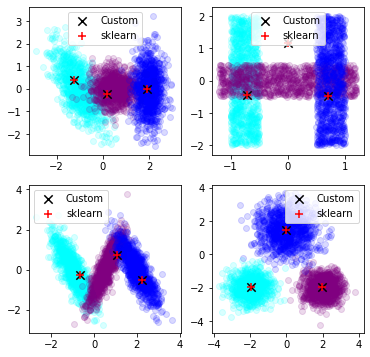

In [18]:
%%time
plot_k_means(3)
plt.savefig('KMeans: Custom vs Sklearn')

# GMM / k-means in Sklearn

Clustering algorithms use the common "fit" and "predict" syntax of sklearn.  

In [19]:
def plot_sk_clust(clusters = 3, clust = GaussianMixture):
    def find_hex(p, colors):
        p = p.reshape(-1,1)
        return to_hex(np.sum(p*colors, axis=0))

    # Create figure
    fig, (axs) = plt.subplots(2,2, figsize = (6,6))
    
    # Go thorugh all data sets 
    for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
        
        # Pull out point data
        points = df.iloc[:,:2].values
        
        # Give list of colors as RGB
        colors = ["#1b9e77", "#d95f02", "#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"][:clusters]
        colors = [np.array(to_rgb(c)) for c in colors]
        colors = np.array(colors)
        
        # SKLEARN 
        
        # Fit Clusters from points
        cl = clust(clusters).fit(points)
        
        # Calculate Color values from clusters
        if clust == GaussianMixture:
            probs = cl.predict_proba(points)
            plot_colors = [find_hex(p,colors) for p in probs]
            
        if clust == KMeans:
            probs = cl.predict(points)
            plot_colors = [colors[p] for p in probs]

        # END SKLEARN
            
        # Plot points with colors
        ax.scatter(df.x, df.y, label = None, c = plot_colors, alpha = .15)
        
    # Add super title
    fig.suptitle(clust.__str__(clust).split(".")[-1][:-2] + "; Clusters: " + str(clusters))
    plt.show()

clustering visualization with Sklearn

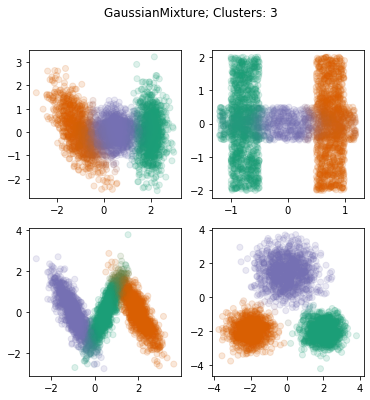

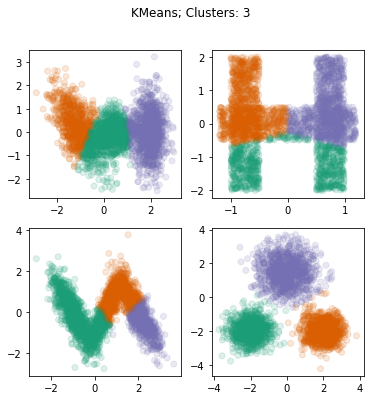

<Figure size 432x288 with 0 Axes>

In [20]:
plot_sk_clust(clusters = 3, clust = GaussianMixture)
plot_sk_clust(clusters = 3, clust = KMeans)
plt.savefig('Sklearn: GMM & KMeans')